In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from io import StringIO

In [ ]:
metrics = pd.DataFrame(columns = ['task', 'precision', 'recall', 'f1', 'rocauc'])


In [ ]:
df = pd.read_csv("./notna_df.csv", sep = ';', index_col=0) 
drop_cols = ['isna', 'student_group','student_name', 'person_id', 'project_id', 'target_multiclass', 'rate_total', 'project_head']
df = df.drop(columns = drop_cols)

cat_features = ['stepen', 'course']
df[cat_features] = df[cat_features].astype(str)

X = df.drop(columns=['target'])
y = df['target']

X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

cat_features = X_train.select_dtypes(include='object').columns.tolist()
for col in cat_features:
    encoder = LabelEncoder()
    X_train[col] = encoder.fit_transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

print('TRAIN')
print(classification_report(y_train, y_pred_train))
print('TEST')
print(classification_report(y_test, y_pred))

pr_train = precision_score(y_train, y_pred_train)
pr_test = precision_score(y_test, y_pred)

rec_train = recall_score(y_train, y_pred_train)
rec_test = recall_score(y_test, y_pred)

f_train = f1_score(y_train, y_pred_train)
f_test = f1_score(y_test, y_pred)

roc_train= roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:, 1])
roc_test= roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])


print('ROC-AUC train', roc_train)
print('ROC-AUC test', roc_test)


TRAIN
              precision    recall  f1-score   support

           0       0.16      0.79      0.27        80
           1       0.97      0.64      0.77       907

    accuracy                           0.65       987
   macro avg       0.57      0.71      0.52       987
weighted avg       0.91      0.65      0.73       987

TEST
              precision    recall  f1-score   support

           0       0.15      0.75      0.24        20
           1       0.97      0.61      0.75       227

    accuracy                           0.62       247
   macro avg       0.56      0.68      0.50       247
weighted avg       0.90      0.62      0.71       247

ROC-AUC train 0.7699145534729879
ROC-AUC test 0.7068281938325992


In [ ]:
task = 'logreg'
new_row = pd.DataFrame({"task": [task + '_train'], "precision": [pr_train],  "recall": [rec_train],  "f1": [f_train],  "rocauc": [roc_train]})
report = classification_report(y_train, y_pred_train)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

new_row = pd.DataFrame({"task": [task + '_test'], "precision": [pr_test],  "recall": [rec_test],  "f1": [f_test],  "rocauc": [roc_test]})
report = classification_report(y_test, y_pred)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

metrics.to_csv('./metrics.csv')
metrics

<ipython-input-20-93749c5205b3>:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, new_row], ignore_index=True)


,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,logreg_train,0.971429,0.637266,0.769640,0.769915,0.16,0.79,0.27
1,logreg_test,0.965278,0.612335,0.749326,0.706828,0.15,0.75,0.24


In [ ]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 5.2 MB/s eta 0:00:00


# optune

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline

def objective(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 1e-4, 10.0, log=True)
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'

    class_weight_option = trial.suggest_categorical('class_weight_option', ['none', 'balanced', 'custom'])

    if class_weight_option == 'none':
        class_weight = None
    elif class_weight_option == 'balanced':
        class_weight = 'balanced'
    else:
        w0 = trial.suggest_float('w0', 0.1, 1.0)
        class_weight = {0: w0, 1: 1.0}

    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        class_weight=class_weight,
        max_iter=1000,
        random_state=42
    )

    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    score = cross_val_score(
        pipeline, X_train, y_train,
        scoring=make_scorer(roc_auc_score),
        cv=5, n_jobs=-1
    ).mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best params:", study.best_params)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best params:", study.best_params)


[I 2025-04-20 14:59:48,142] A new study created in memory with name: no-name-79919e2f-129c-40a1-a7ed-8aae35803afc
[I 2025-04-20 14:59:48,245] Trial 0 finished with value: 0.5 and parameters: {'penalty': 'l1', 'C': 0.00032338792818309095, 'class_weight_option': 'none'}. Best is trial 0 with value: 0.5.
[I 2025-04-20 14:59:48,441] Trial 1 finished with value: 0.6388117752413333 and parameters: {'penalty': 'l2', 'C': 1.442169162874243, 'class_weight_option': 'balanced'}. Best is trial 1 with value: 0.6388117752413333.
[I 2025-04-20 14:59:48,661] Trial 2 finished with value: 0.5 and parameters: {'penalty': 'l2', 'C': 0.007236896422375849, 'class_weight_option': 'custom', 'w0': 0.2769660434018546}. Best is trial 1 with value: 0.6388117752413333.
[I 2025-04-20 14:59:48,891] Trial 3 finished with value: 0.5 and parameters: {'penalty': 'l2', 'C': 0.0003649489471181813, 'class_weight_option': 'none'}. Best is trial 1 with value: 0.6388117752413333.
[I 2025-04-20 14:59:49,194] Trial 4 finished w

Best params: {'penalty': 'l2', 'C': 0.029477704416001466, 'class_weight_option': 'balanced'}


In [ ]:
model = LogisticRegression(**{'penalty': 'l2', 'C': 0.029477704416001466, 'class_weight': 'balanced', 'random_state':42, 'max_iter':1000})

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

print('TRAIN')
print(classification_report(y_train, y_pred_train))
print('TEST')
print(classification_report(y_test, y_pred))

pr_train = precision_score(y_train, y_pred_train)
pr_test = precision_score(y_test, y_pred)

rec_train = recall_score(y_train, y_pred_train)
rec_test = recall_score(y_test, y_pred)

f_train = f1_score(y_train, y_pred_train)
f_test = f1_score(y_test, y_pred)

roc_train= roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:, 1])
roc_test= roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])


print('ROC-AUC train', roc_train)
print('ROC-AUC test', roc_test)


TRAIN
              precision    recall  f1-score   support

           0       0.14      0.74      0.24        80
           1       0.96      0.61      0.75       907

    accuracy                           0.62       987
   macro avg       0.55      0.68      0.50       987
weighted avg       0.90      0.62      0.71       987

TEST
              precision    recall  f1-score   support

           0       0.15      0.75      0.24        20
           1       0.97      0.61      0.75       227

    accuracy                           0.62       247
   macro avg       0.56      0.68      0.50       247
weighted avg       0.90      0.62      0.71       247

ROC-AUC train 0.7521775082690187
ROC-AUC test 0.7167400881057269


In [ ]:
task = 'logreg_optuna'
new_row = pd.DataFrame({"task": [task + '_train'], "precision": [pr_train],  "recall": [rec_train],  "f1": [f_train],  "rocauc": [roc_train]})
report = classification_report(y_train, y_pred_train)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

new_row = pd.DataFrame({"task": [task + '_test'], "precision": [pr_test],  "recall": [rec_test],  "f1": [f_test],  "rocauc": [roc_test]})
report = classification_report(y_test, y_pred)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

metrics.to_csv('./metrics.csv')
metrics

,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,logreg_train,0.971429,0.637266,0.769640,0.769915,0.16,0.79,0.27
1,logreg_test,0.965278,0.612335,0.749326,0.706828,0.15,0.75,0.24
2,logreg_optuna_train,0.963668,0.614112,0.750168,0.752178,0.14,0.74,0.24
3,logreg_optuna_test,0.965278,0.612335,0.749326,0.716740,0.15,0.75,0.24


In [ ]:
X

,stepen,course,total_activity_zulip,reactions_added_zulip,messages_created_zulip,mentions_zulip,max_activity_in_single_day_zulip,avg_activity_per_day_zulip,created_count_wekan,completed_count_wekan,...,total__hours_project_taiga,avg_completion_days_project_taiga,max_hours_per_card_project_taiga,min_hours_per_card_project_taiga,average_hours_per_card_project_taiga,unique_users_project_taiga,avg_operations_commit_git,student_operation_contribution_git,avg_dt_between_commits_git,student_commits_contribution_git
0,Б,4.0,2.0,0.0,2.0,1.0,1.0,0.666667,0.0,1.0,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,М,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,Б,3.0,2.0,0.0,2.0,0.0,1.0,1.000000,0.0,2.0,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.319581,0.108019,0.623277,0.863014
4,С,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6,Б,2.0,44.0,7.0,37.0,35.0,30.0,4.100000,0.0,1.0,...,0.0,0.00,0.0,0.0,0.000000,0.0,0.695814,0.253959,0.562135,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,Б,5.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,1080.0,0.24,40.0,4.0,12.857143,9.0,0.000000,0.000000,0.000000,0.000000
1730,Б,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,1023.0,36.01,30.0,0.0,8.596639,7.0,0.000000,0.000000,0.000000,0.000000
1731,М,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,631.0,12.96,55.0,0.0,7.987342,4.0,0.000000,0.000000,0.000000,0.000000
1734,М,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,690.0,18.72,15.0,0.0,8.518519,3.0,0.000000,0.000000,0.000000,0.000000


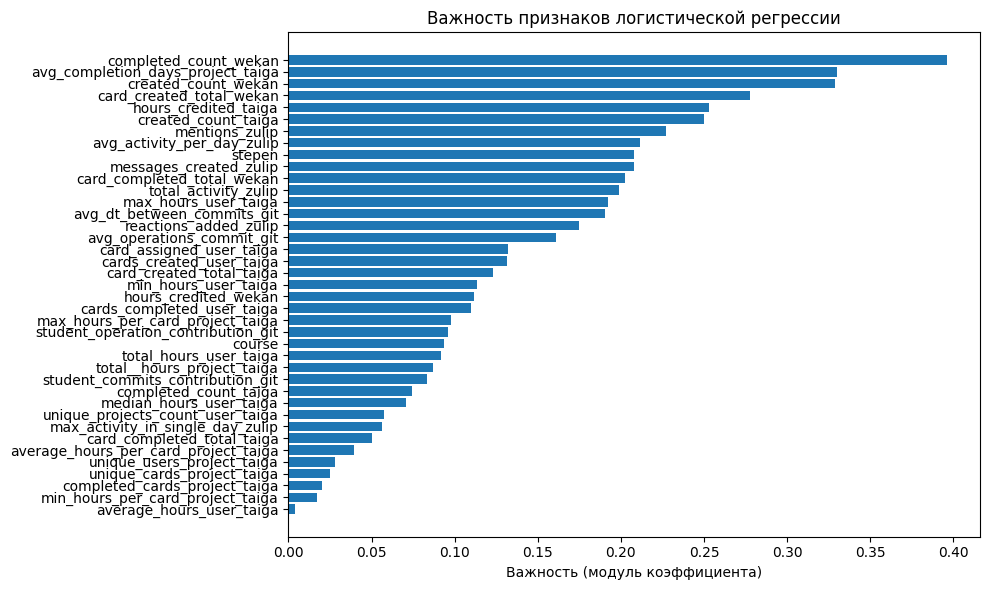

                              Feature  Coefficient  Importance (abs)
9               completed_count_wekan     0.396243          0.396243
30  avg_completion_days_project_taiga    -0.330055          0.330055
8                 created_count_wekan     0.329021          0.329021
12           card_created_total_wekan     0.277886          0.277886
15               hours_credited_taiga     0.252871          0.252871
13                created_count_taiga     0.250185          0.250185
5                      mentions_zulip     0.226955          0.226955
7          avg_activity_per_day_zulip     0.211372          0.211372
0                              stepen    -0.207815          0.207815
4              messages_created_zulip     0.207781          0.207781


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
feature_names = X.columns
coef = model.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Importance (abs)': np.abs(coef)
}).sort_values(by='Importance (abs)', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance (abs)'])
plt.xlabel('Важность (модуль коэффициента)')
plt.title('Важность признаков логистической регрессии')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(feature_importance.head(10))

In [ ]:
feature_names = X.columns
coef = model.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Importance (abs)': np.abs(coef)
}).sort_values(by='Importance (abs)', ascending=False)

cols = feature_importance[:25]['Feature'].values
X = df.drop(columns=['target'])
y = df['target']
X = X.fillna(0)[cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
cat_features = X_train.select_dtypes(include='object').columns.tolist()
for col in cat_features:
    encoder = LabelEncoder()
    X_train[col] = encoder.fit_transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(**{'penalty': 'l2', 'C': 0.029477704416001466, 'class_weight': 'balanced', 'random_state':42, 'max_iter':1000})
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

print('TRAIN')
print(classification_report(y_train, y_pred_train))
print('TEST')
print(classification_report(y_test, y_pred))

pr_train = precision_score(y_train, y_pred_train)
pr_test = precision_score(y_test, y_pred)

rec_train = recall_score(y_train, y_pred_train)
rec_test = recall_score(y_test, y_pred)

f_train = f1_score(y_train, y_pred_train)
f_test = f1_score(y_test, y_pred)

roc_train= roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:, 1])
roc_test= roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])


print('ROC-AUC train', roc_train)
print('ROC-AUC test', roc_test)

TRAIN
              precision    recall  f1-score   support

           0       0.15      0.78      0.25        80
           1       0.97      0.61      0.75       907

    accuracy                           0.62       987
   macro avg       0.56      0.69      0.50       987
weighted avg       0.90      0.62      0.71       987

TEST
              precision    recall  f1-score   support

           0       0.15      0.75      0.24        20
           1       0.97      0.61      0.75       227

    accuracy                           0.62       247
   macro avg       0.56      0.68      0.50       247
weighted avg       0.90      0.62      0.71       247

ROC-AUC train 0.7530319735391401
ROC-AUC test 0.7125550660792951


In [ ]:
task = 'logreg_optuna_selected_25_features'
new_row = pd.DataFrame({"task": [task + '_train'], "precision": [pr_train],  "recall": [rec_train],  "f1": [f_train],  "rocauc": [roc_train]})
report = classification_report(y_train, y_pred_train)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

new_row = pd.DataFrame({"task": [task + '_test'], "precision": [pr_test],  "recall": [rec_test],  "f1": [f_test],  "rocauc": [roc_test]})
report = classification_report(y_test, y_pred)
report = pd.read_csv(StringIO(report), sep='\s\s+', engine='python').iloc[:1, :3].add_suffix('_class=0')
new_row = new_row.merge(report, how = 'cross')
metrics = pd.concat([metrics, new_row], ignore_index=True)

metrics.to_csv('./metrics.csv')
metrics

,task,precision,recall,f1,rocauc,precision_class=0,recall_class=0,f1-score_class=0
0,logreg_train,0.971429,0.637266,0.769640,0.769915,0.16,0.79,0.27
1,logreg_test,0.965278,0.612335,0.749326,0.706828,0.15,0.75,0.24
2,logreg_optuna_train,0.963668,0.614112,0.750168,0.752178,0.14,0.74,0.24
3,logreg_optuna_test,0.965278,0.612335,0.749326,0.716740,0.15,0.75,0.24
4,logreg_optuna_selected_25_features_train,0.968531,0.610805,0.749155,0.753032,0.15,0.78,0.25
5,logreg_optuna_selected_25_features_test,0.965278,0.612335,0.749326,0.712555,0.15,0.75,0.24


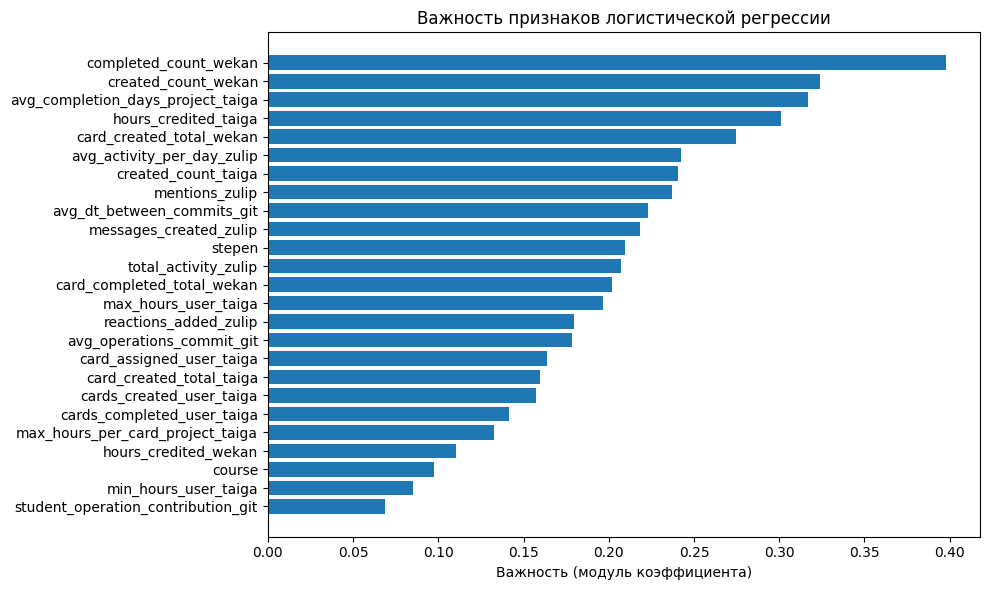

                              Feature  Coefficient  Importance (abs)
0               completed_count_wekan     0.397890          0.397890
2                 created_count_wekan     0.324113          0.324113
1   avg_completion_days_project_taiga    -0.316760          0.316760
4                hours_credited_taiga     0.300900          0.300900
3            card_created_total_wekan     0.274443          0.274443
7          avg_activity_per_day_zulip     0.242100          0.242100
5                 created_count_taiga     0.240718          0.240718
6                      mentions_zulip     0.237224          0.237224
13         avg_dt_between_commits_git     0.223218          0.223218
9              messages_created_zulip     0.218520          0.218520


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
feature_names = cols
coef = model.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Importance (abs)': np.abs(coef)
}).sort_values(by='Importance (abs)', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance (abs)'])
plt.xlabel('Важность (модуль коэффициента)')
plt.title('Важность признаков логистической регрессии')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(feature_importance.head(10))

In [ ]:
feature_importance.round(2).to_csv('feature_importance_logreg.csv', sep = ';')

In [ ]:
metrics.round(2).to_csv('metrics.csv', sep=';')